# Multi-agent supervisor

----------------------------------------------------------------------------------------------------------------------------------
*This section is taken from a yt video published by the [LangChain channel](https://www.youtube.com/@LangChain) on Multi-Agent workflows at this [link](https://youtu.be/hvAPnpSfSGo?si=QJw60byA9oRtSE5V). We will go over the notebook and comment relevant/difficult sections.*

----------------------------------------------------------------------------------------------------------------------------------

[**Supervisor**](../../../concepts/multi_agent#supervisor) is a multi-agent architecture where **specialized** agents are coordinated by a central **supervisor agent**. The supervisor agent controls all communication flow and task delegation, making decisions about which agent to invoke based on the current context and task requirements.

In this tutorial, you will build a supervisor system with two agents — a research and a math expert. By the end of the tutorial you will:

1. Build specialized research and math agents
2. Build a supervisor for orchestrating them with the prebuilt [`langgraph-supervisor`](https://langchain-ai.github.io/langgraph/agents/multi-agent/#supervisor)
3. (*Optional*)  Build a supervisor from scratch
4. (*Optional*) Implement advanced task delegation

If you understood multi-agent-collaboration from the previous section, you probably won't have any problem following this implementation. 

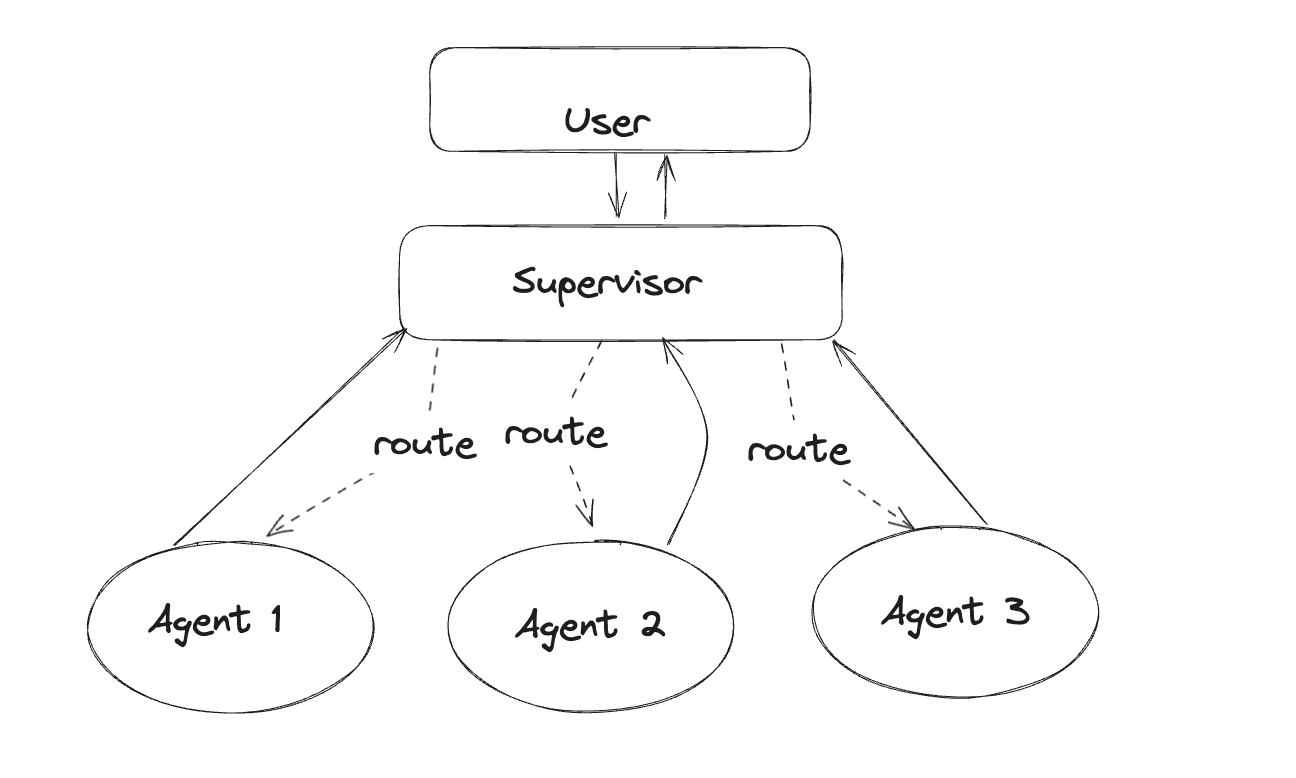

## Setup

First, let's install required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install -U langgraph langgraph-supervisor langchain-tavily "langchain[openai]"

In [2]:
import getpass
import os
from dotenv import load_dotenv

load_dotenv()

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

## 1. Create worker agents

First, let's create our specialized worker agents — research agent and math agent:

* Research agent will have access to a web search tool using [Tavily API](https://tavily.com/)
* Math agent will have access to simple math tools (`add`, `multiply`, `divide`)

### Research agent

For web search, we will use `TavilySearch` tool from `langchain-tavily`:

In [3]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("who is the mayor of NYC?")

print(web_search_results["results"][0]["content"])

Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. In Albany, Eric built winning coalitions to advance New York City’s values and goals, helping to push through measures to protect tenants and workers, combat gun violence, end the NYPD’s abuses of stop and frisk, and advance human rights — including marriage equality. NYC is a trademark and service mark of the City of New York.


To create individual worker agents, we will use LangGraph's prebuilt [agent](../../../agents/agents#basic-configuration).

In [4]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

Let's run the agent to verify that it behaves as expected. 

> **Note:** We'll use `pretty_print_messages` helper to render the streamed agent outputs nicely

In [5]:
# hide-cell
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [6]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "who is the mayor of NYC?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_CZFaadpctIo1GB0Wmc9knM3g)
 Call ID: call_CZFaadpctIo1GB0Wmc9knM3g
  Args:
    query: current mayor of New York City


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "current mayor of New York City", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Mayor_of_New_York_City", "title": "Mayor of New York City - Wikipedia", "content": "The current mayor is Eric Adams, who was elected on November 2, 2021, and took office shortly after midnight on January 1, 2022.", "score": 0.9372167, "raw_content": null}, {"url": "https://www.nyc.gov/office-of-the-mayor/index.page", "title": "Office of the Mayor | Overview | City of New York - NYC.gov", "content": "Eric L.​​ Mayor Eric Adams has serv

### Math agent

For math agent tools we will use [vanilla Python functions](../../../agents/tools#define-simple-tools):

In [7]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

Let's run the math agent:

In [8]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_6BmUBEDqbv1XRe1bKPxrSXFn)
 Call ID: call_6BmUBEDqbv1XRe1bKPxrSXFn
  Args:
    a: 3
    b: 5


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (call_OLCHyZrukUNMfziz21J70gw1)
 Call ID: call_OLCHyZrukUNMfziz21J70gw1
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

56




## 2. Create supervisor with `langgraph-supervisor`

To implement out multi-agent system, we will use `create_supervisor` from the prebuilt [`langgraph-supervisor`]([https://github.com/langchain-ai/langgraph-supervisor-py]) library:

In [9]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4.1"),
    agents=[research_agent, math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True, # if True, adds a pair of (AIMessage, ToolMessage) to the message history qhen returning control to the supervisor, indicating a handoff has occurred
    output_mode="full_history", # add the entire agent message history
).compile()

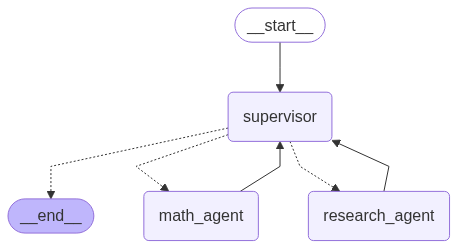

In [10]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

Let's now run it with a query that requires both agents:

* research agent will look up the necessary GDP information
* math agent will perform division to find the percentage of NY state GDP, as requested

In [11]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

The US GDP in 2024 was estimated at $28.4 trillion, and New York State's GDP was $2.297 trillion. New York

--------------------------

From here on (section 3 and 4) the material is a little more advanced. The tutorial goes on to re-create the above system from scratch, which gives much more control over the workflow. We should implement this in the (near) future.

If you want to continue, you should be familiar with `InjectedState`, which is thoroughly explained in the [InjectedState notebook](https://github.com/MatteoFalcioni/GenAI/blob/main/09_LangGraph_Advanced/09.3_InjectedState.ipynb). 

--------------------------

## 3. Create supervisor from scratch

Let's now implement this same multi-agent system from scratch. We will need to:

1. Set up how the supervisor [communicates](#set-up-agent-communication) with individual agents
2. Create the [supervisor agent](#create-supervisor-agent)
3. [Combine]() supervisor and worker agents into a single multi-agent graph.

### Set up agent communication

We will need to define a way for the supervisor agent to communicate with the worker agents. A common way to implement this in multi-agent architectures is using [**handoffs**](https://langchain-ai.github.io/langgraph/how-tos/multi_agent/#handoffs), where one agent *hands off* control to another. Handoffs allow you to specify:

- **destination**: target agent to transfer to
- **payload**: information to pass to that agent

We will implement handoffs via **handoff tools** and give these tools to the supervisor agent: when the supervisor calls these tools, it will hand off control to a worker agent, passing *the full message history* to that agent.

In [12]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


# helper function to create handoff tool
def create_handoff_tool(*, agent_name: str, description: str | None = None):    #  * means: from here on, all arguments must be passed as keyword arguments
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    # the actual handoff tool
    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState], # Injects state (-> thus returns Command)
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        # highlight-next-line
        return Command(
            # highlight-next-line
            goto=agent_name,  # (1)!    
            # highlight-next-line
            update={**state, "messages": state["messages"] + [tool_message]},  # (2)!
            # highlight-next-line
            graph=Command.PARENT,  # (3)!
        )

    return handoff_tool


# Handoffs
assign_to_research_agent = create_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_math_agent = create_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)

1. Name of the agent or node to hand off to.
2. Take the agent's messages and add them to the parent's (a.k.a., the supervisor) state as part of the handoff. The next agent will see the parent state.
3. Indicate to LangGraph that we need to [navigate to agent node](https://langchain-ai.github.io/langgraph/how-tos/graph-api/#navigate-to-a-node-in-a-parent-graph) in a [**parent** multi-agent graph](https://langchain-ai.github.io/langgraph/concepts/subgraphs/#subgraphs). As a matter off act, now we are using the supervisor as the starting point for two "subgraphs" which are our worker agents.

> ***A pythonic note on `*` and `**`***
>
> **`*` in function signature**
>
> ```python
> def create_handoff_tool(*, agent_name: str, description: str | None = None):
> ```
>
> * The asterisk (`*`) in the function definition means that **all following parameters must be passed as keyword arguments**.
>
> * Example:
>
>   ```python
>   create_handoff_tool(agent_name="foo", description="bar")   
>   create_handoff_tool("foo", "bar")                           
>   ```
>
> * This improves **clarity**, **safety**, and **future-proofing** of function calls.
>
> **`**` in expression or function call**
>
> ```python
> agent_input = {**state, "messages": [task_description_message]}
> ```
>
> * The double asterisk (`**`) is used for **dictionary unpacking**.
>
> * It expands the key-value pairs from the `state` dictionary into a new dictionary.
>
> * If the key `"messages"` already exists in `state`, it will be **overridden** by the new value.
>
> * Example:
>
>   ```python
>   state = {
>       "messages": [...],
>       "remaining_steps": 2
>   }
>
>   {**state, "messages": ["new message"]} ➔ {
>       "messages": ["new message"],
>       "remaining_steps": 2
>   }
>   ```
>
> #### Summary
>
> * `*` (in function signature): enforces keyword-only arguments.
> * `**` (in expressions): expands dictionary contents.


### Create supervisor agent

Then, let's create the supervisor agent with the handoff tools we just defined. We will use the prebuilt [`create_react_agent`]:

In [13]:
supervisor_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[assign_to_research_agent, assign_to_math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

### Create multi-agent graph

Putting this all together, let's create a graph for our overall multi-agent system. We will add the supervisor and the individual agents as subgraph nodes.

In [ ]:
from langgraph.graph import END

# Define the multi-agent supervisor graph
supervisor = (
    StateGraph(MessagesState)
    # NOTE: `destinations` is only needed for visualization and doesn't affect runtime behavior
    .add_node(supervisor_agent, destinations=("research_agent", "math_agent", END))
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    # always return back to the supervisor
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

Notice that we've added explicit [edges](../../../concepts/low_level#edges) from worker agents back to the supervisor — this means that they are guaranteed to return control back to the supervisor. If you want the agents to respond directly to the user (i.e., turn the system into a router, you can remove these edges).

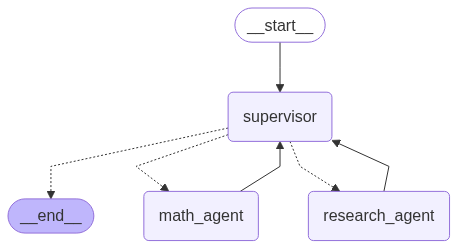

In [15]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

With the multi-agent graph created, let's now run it!

In [16]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================== Ai Message ==================================
Name: research_agent

- US GDP in 2024 was approximately $29.18 trillion (source: Statista, https://www.statista.com/statistics/263591/gross-domestic-product-gdp-of-the-united-states/)
- New York State GDP in 2024 was approximately $2.05 trillion (source: USAFacts, https://usafacts.org/answers/what-is-the-gross-domestic-product-gdp/state/new-york/)
- New York State GDP as a percentage of US GDP in 2024: about 7%


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================== Ai Message ===============

Let's examine the full resulting message history:

In [17]:
for message in final_message_history:
    message.pretty_print()

================================ Human Message =================================

find US and New York state GDP in 2024. what % of US GDP was New York state?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_agent (call_AeY08t8QmI9WQJNqOFdEpqMI)
 Call ID: call_AeY08t8QmI9WQJNqOFdEpqMI
  Args:
================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent
================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_h5YR5x6YDb6ORf7TZI1KiPaf)
 Call ID: call_h5YR5x6YDb6ORf7TZI1KiPaf
  Args:
    query: US GDP in 2024
    search_depth: advanced
  tavily_search (call_bAPolcmfQtCY76XdnI2Uu56y)
 Call ID: call_bAPolcmfQtCY76XdnI2Uu56y
  Args:
    query: New York state GDP in 2024
    search_depth: advanced
================================= Tool M

------------
**Important**

You can see that the supervisor system appends **all** of the individual agent messages (i.e., their internal tool-calling loop) to the full message history. This means that on every supervisor turn, supervisor agent sees this full history. If you want more control over:

* **how inputs are passed to agents**: you can use LangGraph `Send()` primitive to directly send data to the worker agents during the handoff. See the [task delegation](#create-delegation-tasks) example below
* **how agent outputs are added**: you can control how much of the agent's internal message history is added to the overall supervisor message history by wrapping the agent in a separate node function:

```python
def call_research_agent(state):
    # return agent's final response,
    # excluding inner monologue
    response = research_agent.invoke(state)
    # highlight-next-line
    return {"messages": response["messages"][-1]}
```

------------

## 4. Create delegation tasks

So far the individual agents relied on **interpreting full message history** to determine their tasks. An alternative approach is to ask the supervisor to **formulate a task explicitly**. We can do so by adding a `task_description` parameter to the `handoff_tool` function.

In [18]:
from langgraph.types import Send


def create_task_description_handoff_tool(
    *, agent_name: str, description: str | None = None
):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        # this is populated by the supervisor LLM
        task_description: Annotated[
            str,
            "Description of what the next agent should do, including all of the relevant context.",
        ],
        # these parameters are ignored by the LLM
        state: Annotated[MessagesState, InjectedState],
    ) -> Command:
        
        task_description_message = {"role": "user", "content": task_description}
        agent_input = {**state, "messages": [task_description_message]}     # pass state as input but replace messages with the task description to messages   
        return Command(
            # highlight-next-line
            goto=[Send(agent_name, agent_input)],
            graph=Command.PARENT,
        )

    return handoff_tool


assign_to_research_agent_with_description = create_task_description_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_math_agent_with_description = create_task_description_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)

supervisor_agent_with_description = create_react_agent(
    model="openai:gpt-4.1",
    tools=[
        assign_to_research_agent_with_description,
        assign_to_math_agent_with_description,
    ],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this assistant\n"
        "- a math agent. Assign math-related tasks to this assistant\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

supervisor_with_description = (
    StateGraph(MessagesState)
    .add_node(
        supervisor_agent_with_description, destinations=("research_agent", "math_agent")
    )
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

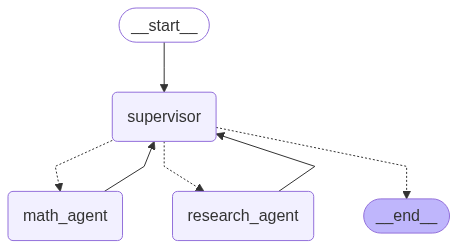

In [20]:
from IPython.display import display, Image

display(Image(supervisor_with_description.get_graph().draw_mermaid_png()))

>**Note:**
>
>We're using the [`Send()`](https://langchain-ai.github.io/langgraph/reference/types/#langgraph.types.Send) primitive in the `handoff_tool`. This means that instead of receiving the full `supervisor` graph state as input, each worker agent only sees the contents of the `Send` payload. In this example, we're sending the task description as a single "human" message.

>**Note:** Given how we constructed our tool, *it's the supervisor that chooses the task description* at runtime. 

Let's now try running it with the same input query:

In [19]:
for chunk in supervisor_with_description.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
    subgraphs=True,
):
    pretty_print_messages(chunk, last_message=True)

Update from subgraph supervisor:


	Update from node agent:


	================================== Ai Message ==================================
	Name: supervisor
	Tool Calls:
	  transfer_to_research_agent (call_DcDXWQvz23PyY4DK4dl2sbGX)
	 Call ID: call_DcDXWQvz23PyY4DK4dl2sbGX
	  Args:
	    task_description: Find the most recent 2024 estimates or projections of US GDP and New York state GDP. If 2024 data is not available, use the latest available official numbers and note the year. Provide sourced numbers for both US and New York state GDP.


Update from subgraph research_agent:


	Update from node agent:


	================================== Ai Message ==================================
	Name: research_agent
	Tool Calls:
	  tavily_search (call_Kirm3QGCQ8w0retf6sSsU3jg)
	 Call ID: call_Kirm3QGCQ8w0retf6sSsU3jg
	  Args:
	    query: 2024 US GDP estimate or projection
	    search_depth: advanced
	  tavily_search (call_PxxZ0S7X8uSmV1fV2q8Ga1RR)
	 Call ID: call_PxxZ0S7X8uSmV1fV2q8Ga1RR
	  A